## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math
from scipy.stats import norm
#import PrettyTable

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, addOverflow
from helper_functions import deltaR, deltaPhi, drawCMS

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = 'v6'
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
lumi = 23.02*1000

if data_year == 2022:
    fpath['data'] = data_path + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
    fpath['signal'] = data_path + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    
for k, T in tree.items():
    branch_names = T.keys()

In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
sel_ev_post = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterR = {}
cscClusterZ = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpread = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterMet_dPhi = {}

cscClusterNStation = {}
cscClusterDphi = {}
nCscClusters = {}


#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}
dtClusterMaxStationRatio = {}
dtClusterMet_dPhi = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}


#L1 plateau
first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}


first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}

#Angular variables
dPhi_csc_csc = {}
dEta_csc_csc = {}
dR_csc_csc = {}
dt_csc_csc = {}
dPhi_csc_dt = {}
dEta_csc_dt = {}
dR_csc_dt = {}

## Settings

In [4]:
category = 0#-1#0
category = 1
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True
do_L1_plateau = True

plot_string = ""
#plot_string = "_jet_veto"
#plot_string = "_csc_time_spread_cut"
#plot_string = "_csc_in_time_cut"
#plot_string = ""
#plot_string = "_ME_veto"
#plot_string = "_ME_veto_HLT_eta_cut"
#plot_string = "_ME_veto_HLT_eta_cut_at_least_1_cluster"
#plot_string = "_ME_veto_HLT_eta_cut_in_time_cut_at_least_1_cluster"
#plot_string+= "_exactly_1_csc_cluster"

plot_string+= "_exactly_2_csc_clusters_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_MB_veto"

In [5]:
for a in branch_names:
    #if "MB1" in str(a):
    #    print(a)
    if "dtRechitClusterMaxStationRatio" in str(a):
        print(a)
    #if "atio" in str(a):
    #    print(a)

b'dtRechitClusterMaxStationRatio'


In [6]:
for k, T in tree.items():
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
########### SELECTION: CLUSTERS ############
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = jet_veto_csc
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_not(jet_veto_csc)       

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    
          
    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))

    #ME11 and ME12 veto
    ME11_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )      

       
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto,ME12_veto)
                                   ) 
    if do_HLT_eta_cut:
        sel_csccluster = np.logical_and(sel_csccluster,sel_trgCluster)
        
        
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    MB1_veto = T.array('dtRechitClusterNHitStation1') == 0
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto)
        
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose
     
    
    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #If trigger:
    #We don't have correct trigger emulation in signal at the moment
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)

    #At least one pre-selected csc cluster, always required
    sel_ev[k] = np.logical_and(sel_ev[k],sel_csccluster.sum()>=1)
    
    
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
           
########### BRANCHES ############

    
    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMet_dPhi[k] =  T.array('dtRechitCluster' + cluster_index + 'Met_dPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStationRatio[k] = T.array('dtRechitCluster' + cluster_index + 'MaxStationRatio')[sel_dtcluster][sel_ev[k]][:,:]
        
    cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMet_dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[sel_csccluster][sel_ev[k]][:,:]
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
      
    sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
    sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
       
    sel_jetveto_dt[k] = jet_veto_dt[sel_dtcluster][sel_ev[k]][:,:]
    sel_muonveto_dt[k] = muon_veto_dt[sel_dtcluster][sel_ev[k]][:,:]        

    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]]
       
    hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
    sel_ev[k] = sel_ev[k][ sel_ev[k] ]

    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))

* Study delta phi with met
* Apply at least one csc cluster requirement
* Apply L1 plateau

# L1 plateau

In [7]:
first_in_tr1 = {}
first_in_tr2 = {}
first_in_tr3 = {}

for k in tree_keys:
    first_in_ME11[k] = (cscClusterR[k][:,0]>100)&(cscClusterR[k][:,0]<275) &(abs(cscClusterZ[k][:,0])>580)&(abs(cscClusterZ[k][:,0])<632) 
    first_in_ME12[k] = (cscClusterR[k][:,0]>275)&(cscClusterR[k][:,0]<465) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)
    first_in_ME13[k] = (cscClusterR[k][:,0]>505)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)

    first_in_ME21[k] = (cscClusterR[k][:,0]>139)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>789)&(abs(cscClusterZ[k][:,0])<850)
    first_in_ME22[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>791)&(abs(cscClusterZ[k][:,0])<850)

    first_in_ME31[k] = (cscClusterR[k][:,0]>160)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>915)&(abs(cscClusterZ[k][:,0])<970)
    first_in_ME32[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>911)&(abs(cscClusterZ[k][:,0])<970)

    first_in_ME41[k] = (cscClusterR[k][:,0]>178)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    first_in_ME42[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    
    first_in_plateau_ME11[k] = first_in_ME11[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME21[k] = first_in_ME21[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME31[k] = first_in_ME31[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME41[k] = first_in_ME41[k] & (cscClusterSize[k][:,0]>=500)

    first_in_plateau_ME12[k] = first_in_ME12[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME13[k] = first_in_ME13[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME22[k] = first_in_ME22[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME32[k] = first_in_ME32[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME42[k] = first_in_ME42[k] & (cscClusterSize[k][:,0]>=200)    
    
    first_in_plateau[k] = first_in_plateau_ME11[k] | first_in_plateau_ME12[k] | first_in_plateau_ME13[k] | first_in_plateau_ME21[k] | first_in_plateau_ME22[k] | first_in_plateau_ME31[k] | first_in_plateau_ME32[k] | first_in_plateau_ME41[k] | first_in_plateau_ME42[k]
    

    first_in_tr1[k] = np.logical_and( cscClusterSize[k][:,0] >= 100, np.logical_and(cscClusterNStation[k][:,0]>=2, np.abs(cscClusterEta[k][:,0])<1.9))
    first_in_tr2[k] = np.logical_and( cscClusterSize[k][:,0] >= 200, np.logical_and(cscClusterNStation[k][:,0]==1, np.abs(cscClusterEta[k][:,0])<1.9))
    first_in_tr3[k] = np.logical_and( cscClusterSize[k][:,0] >= 500, np.abs(cscClusterEta[k][:,0])>=1.9)
 
    sel_ev[k] = np.logical_and(sel_ev[k],first_in_plateau[k])
    
    if category==1:
        dPhi_csc_csc[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), cscClusterPhi[k][:,1].flatten() ) )
        dEta_csc_csc[k] = (  cscClusterEta[k][:,0].flatten() - cscClusterEta[k][:,1].flatten() )
        dR_csc_csc[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), cscClusterEta[k][:,1].flatten(), cscClusterPhi[k][:,1].flatten() )
        dt_csc_csc[k]   = (  cscClusterTime[k][:,0].flatten() - cscClusterTime[k][:,1].flatten() )
        min_dphi = 0#.65
        sel_ev_post[k] = np.logical_and(sel_ev[k],np.abs(dPhi_csc_csc[k])>min_dphi)
    if category==2:
        dPhi_csc_dt[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten() ) )
        dEta_csc_dt[k] = (  cscClusterEta[k][:,0].flatten() - dtClusterEta[k][:,0].flatten() )
        dR_csc_dt[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), dtClusterEta[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten() )
        sel_ev_post[k] = sel_ev[k]

## One example plot

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

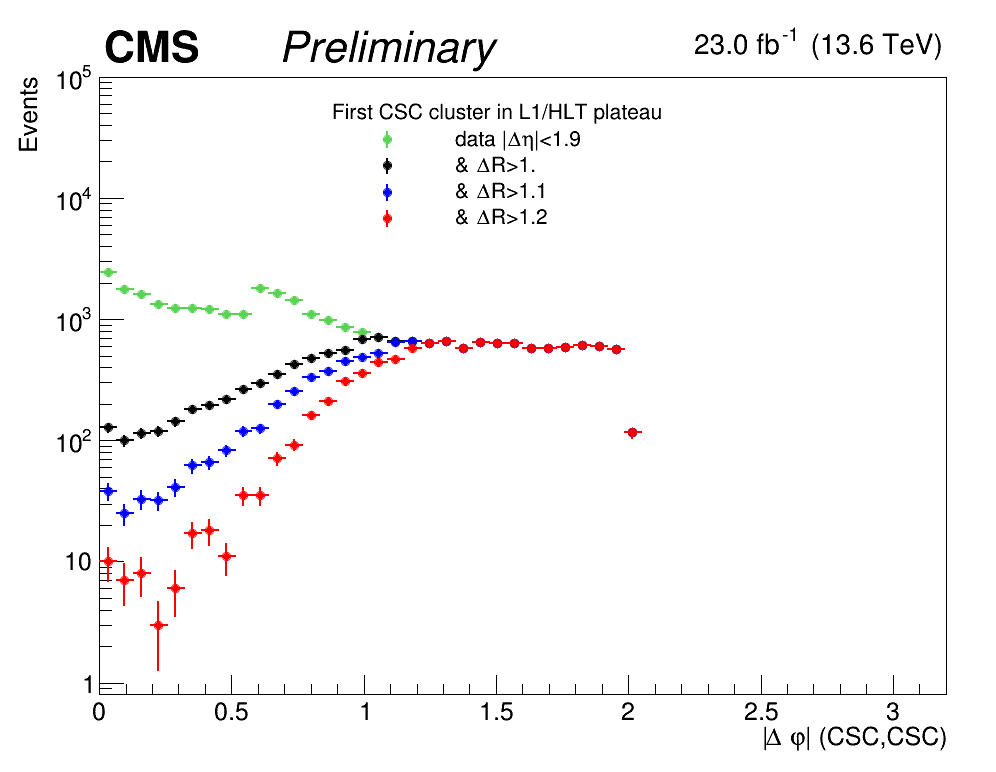

In [8]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.2,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in ['data']:#tree_keys:
        cut = sel_ev_post[k] & (np.abs(dEta_csc_csc[k])<1.9) & (np.abs(dPhi_csc_csc[k])<2) #& (dR_csc_csc[k]>0.8) # & ((np.abs(dPhi_csc_csc[k])>0.9)) #& (dR_csc_csc[k]>np.abs(dPhi_csc_csc[k]))# & ((np.abs(dPhi_csc_csc[k])>1.1))#  & (sel_jetveto_csc[k][:,1]==False) #& ((np.abs(dPhi_csc_csc[k])>1.))# & (np.abs(dEta_csc_csc[k])<0.4)) #& (np.abs(cscClusterTime[k][:,1])<50) #& (sel_muonveto_csc[k][:,0]==False) #& (sel_jetveto_csc[k][:,0]==True) #& (dEta_csc_csc[k]<1.9)
        h0[k] = create_TH1D( np.abs(dPhi_csc_csc[k][cut]),title="",axis_title = ['|#Delta #varphi| (CSC,CSC)','Events'], binning=[50,0,3.2])
        h0[k].SetLineColor(8)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(8)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        #h1[k] = create_TH1D( np.abs(dPhi_csc_csc[k][cut & first_in_tr1[k] ]),title="",axis_title = ['|#Delta #varphi| (CSC,CSC)','Events'], binning=[50,0,3.2])
        h1[k] = create_TH1D( np.abs(dPhi_csc_csc[k][cut & (dR_csc_csc[k]>1.) ]),title="",axis_title = ['|#Delta #varphi| (CSC,CSC)','Events'], binning=[50,0,3.2])
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
            
        #h2[k] = create_TH1D(np.abs(dPhi_csc_csc[k][ cut & first_in_tr2[k] ] ),title="",axis_title = ['phi','Events'], binning=[50,0,3.2])
        h2[k] = create_TH1D( np.abs(dPhi_csc_csc[k][cut & (dR_csc_csc[k]>1.1) ]),title="",axis_title = ['|#Delta #varphi| (CSC,CSC)','Events'], binning=[50,0,3.2])
        h2[k].SetLineColor(4)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(4)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral()) 
        
        #h3[k] = create_TH1D(np.abs(dPhi_csc_csc[k][ cut & first_in_tr3[k] ] ),title="",axis_title = ['phi','Events'], binning=[50,0,3.2])
        h3[k] = create_TH1D( np.abs(dPhi_csc_csc[k][cut & (dR_csc_csc[k]>1.2) ]),title="",axis_title = ['|#Delta #varphi| (CSC,CSC)','Events'], binning=[50,0,3.2])
        h3[k].SetLineColor(2)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(2)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.001)
        if 'data' in k:
            h0[k].Draw('PE same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            h3[k].Draw('PE same')
            #leg.AddEntry(h0[k],"Data |#Delta#eta|<1.9 & #DeltaR>1","PE")
            #leg.AddEntry(h1[k],"Trigger cluster |#eta|<1.9, 2 stations, n hits#geq100","PE")
            #leg.AddEntry(h2[k],"Trigger cluster |#eta|<1.9, 1 station, n hits#geq200","PE")
            #leg.AddEntry(h3[k],"Trigger cluster |#eta|#geq1.9, n hits#geq500","PE")
            leg.AddEntry(h0[k],"data |#Delta#eta|<1.9","PE")
            leg.AddEntry(h1[k],"& #DeltaR>1.","PE")
            leg.AddEntry(h2[k],"& #DeltaR>1.1","PE")
            leg.AddEntry(h3[k],"& #DeltaR>1.2","PE")
        else:
            h1[k].Draw('HISTO same')
            h2[k].Draw('HISTO same')
            h3[k].Draw('HISTO same')
            leg.AddEntry(h2[k],"same cuts, signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_dR_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_dR_categories"+lab+plot_string+".png")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories_dR_larger_1"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories_dR_larger_1"+lab+plot_string+".png")
#can.Close()        

## One example 2D plot

# ABCD

* Tune min dphi cut to remove poorly-clustered events

In [9]:

x_min = 50
x_max = 100#1050
n_bins = 10

#x_max = 200
#n_bins = 10
#blinding_bin = 2
#blinding_bin = 1
#n_bins = 15#3
    
#Tune
#--OK tested this configuration:
x_max = 250
n_bins = 10
blinding_bin = 2
blinding_bin = 2
    

    
#n_bins = 4
#Currently testing:
#x_max = 150
#n_bins = 10
#blinding_bin = 4
#blinding_bin = 1
    
#n_bins = 5
   
#Tune
#x_max = 550
#n_bins = 10
    

#Tune
#x_max = 1050
#n_bins = 10

bins = np.linspace(x_min,x_max,n_bins+1)
bins_center = bins[0:-1]+0.5*(x_max-x_min)/n_bins

PHI_MIN = 0.7
PHI_MIN_IT = 1.25
PHI_CUT = 2.#1.5
PHI_MAX = 2.

#DR_MIN  = 1.1
#PHI_MIN = 0.1+DR_MIN#0.7
PHI_MAX = 2#3.15#2

N_MIN = x_min
N_MAX = x_max
N_CUT = bins[blinding_bin]

n_ev = 5000

pre_cut = {}

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

x  pred  up down true 
100.0 0.0 0.0 0.0 0.0
x  pred  up down true 
120.0 0.0 0.0 0.0 0.0
x  pred  up down true 
140.0 0.0 0.0 0.0 0.0
x  pred  up down true 
160.0 0.0 0.0 0.0 0.0
x  pred  up down true 
180.0 0.0 0.0 0.0 0.0
x  pred  up down true 
200.0 0.0 0.0 0.0 0.0
x  pred  up down true 
220.0 0.0 0.0 0.0 0.0
x  pred  up down true 
240.0 0.0 0.0 0.0 0.0






/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

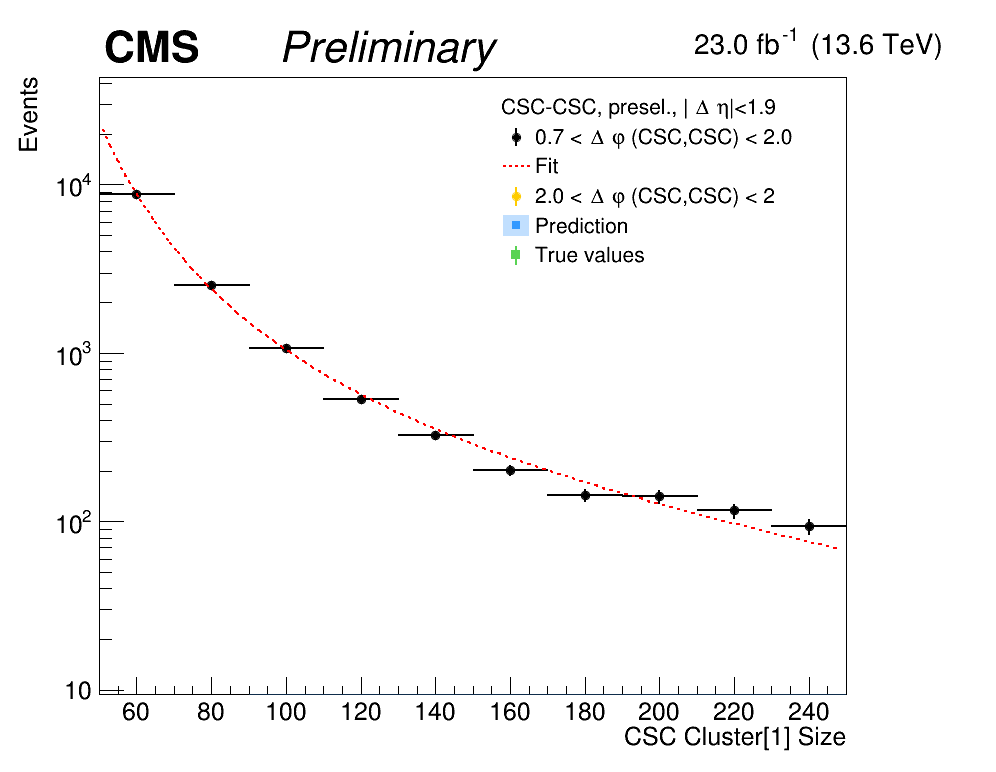

In [10]:
if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    hnot = {}
    hunbl = {}
    hpred= {}
    can.cd()
    
    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",x_min,x_max)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    foot = rt.TF1("foot","exp([0]*x + [1]/(x))/[2]",x_min,x_max)
    foot.SetParameter(0,-0.0069210997892010535)
    foot.SetParameter(1,426.659535750436)
    foot.SetParameter(2,195.1699385925665)
    #e^{-x/(a+bx)
    
    scale = True
    scale = False
    do_blind = True
    
    x_pred = []
    x_pred_unc = []
    y_pred = []
    y_pred_up = []
    y_pred_down = []
    y_pred_unc = []

    for k in tree_keys:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dR = np.abs(  dR_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        tmp_t2 = (cscClusterTime[k][:,1])
        
        blind = (cscClusterSize[k][:,1] < bins[blinding_bin] if do_blind else 100000 )
        unblind = (cscClusterSize[k][:,1] >= bins[blinding_bin])
        
        #Eta<1.9      
        leg.SetHeader('CSC-CSC, presel., |#Delta #eta|<1.9')
        pre_cut[k] = sel_ev_post[k] & (tmp_deta<1.9) # & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 
        
        #Invert jet veto
        #leg.SetHeader('CSC-CSC, presel., inverted jet veto')
        #pre_cut[k] = sel_ev_post[k] & (sel_jetveto_csc[k][:,1]==False) #& (np.abs(dPhi_csc_csc[k])>PHI_MIN)# & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 

        #Eta>=1.9      
        #leg.SetHeader('CSC-CSC, presel., |#Delta #eta|#geq1.9')
        #pre_cut[k] = sel_ev_post[k] & (tmp_deta>=1.9)# & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 

        #Eta>=1.9 OOT negative
        #leg.SetHeader('CSC-CSC, presel., |#Delta #eta|#geq1.9')
        #pre_cut[k] = sel_ev_post[k] & (tmp_deta>=1.9) & (tmp_t2<-15)# & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 
        
        #Eta<1.9 & DR>0.8  
        #leg.SetHeader('CSC-CSC, presel., |#Delta#eta|<1.9, #DeltaR>'+str(DR_MIN))
        #pre_cut[k] = sel_ev_post[k] & (tmp_deta<1.9) & (tmp_dR>DR_MIN) # & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 
         
        cut_phi_small = (tmp_dphi>=PHI_MIN) & (tmp_dphi<PHI_CUT)
        cut_phi_large = (tmp_dphi>=PHI_CUT) & (tmp_dphi<PHI_MAX) 
        cut = (cut_phi_small==True)
        cut_label = str(PHI_MIN)+" < #Delta #varphi (CSC,CSC) < "+str(PHI_CUT)
        cut_not = (cut_phi_large==True)
        cut_not_label = str(PHI_CUT)+" < #Delta #varphi (CSC,CSC) < "+str(PHI_MAX)
        
        
        csc_size_2 = cscClusterSize[k][ pre_cut[k] & cut ][:,1]
        csc_size_2_not = cscClusterSize[k][ pre_cut[k] & cut_not & blind ][:,1]
        csc_size_2_unbl = cscClusterSize[k][ pre_cut[k] & cut_not & unblind ][:,1]

        
        h[k] = create_TH1D(csc_size_2.flatten(),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        h[k].SetLineColor(1)
        h[k].SetLineWidth(2)
        h[k].SetMarkerColor(1)
        h[k].SetMarkerStyle(20)
        h[k].SetMarkerSize(1.2)
        
        
        hnot[k] = create_TH1D(csc_size_2_not.flatten(),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        hnot[k].SetLineColor(800)
        hnot[k].SetLineWidth(2)
        hnot[k].SetMarkerColor(800)
        hnot[k].SetMarkerStyle(20)
        hnot[k].SetMarkerSize(1.2)
        
        hunbl[k] = create_TH1D(csc_size_2_unbl.flatten(),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        hunbl[k].SetLineColor(8)
        hunbl[k].SetLineWidth(2)
        hunbl[k].SetMarkerColor(8)
        hunbl[k].SetMarkerStyle(21)
        hunbl[k].SetMarkerSize(1.2)
                
        if scale:
            h[k].Scale(1./h[k].Integral() if h[k].Integral()>0 else 1.)
            hnot[k].Scale(1./hnot[k].Integral() if hnot[k].Integral()>0 else 1.)
            hunbl[k].Scale(1./hunbl[k].Integral() if hunbl[k].Integral()>0 else 1.)
            
        h[k].SetMaximum(  5*max(1. if scale else 1.9, max(h[k].GetMaximum(),hnot[k].GetMaximum()) )  )        
        min_y = max(max(h[k].GetMinimum(),1.e-500 if scale else 0.9), max(hnot[k].GetMinimum(),1.e-500 if scale else 0.9))
        h[k].SetMinimum(min(min_y*0.1,0.6 if min_y==0 else 1000))        
        
        if 'data' in k:         
            h[k].Fit('f1', 'LRSQ+', '', x_min,x_max)
            my_f1 = h[k].GetFunction("f1")            
            h[k].GetListOfFunctions().Remove(h[k].GetFunction("f1"))
            #print(my_f1.GetParameter(0),my_f1.GetParError(0))
            #print(my_f1.GetParameter(1),my_f1.GetParError(0))
            #print(my_f1.GetParameter(2),my_f1.GetParError(0))
            my_f1_up = my_f1.Clone("my_f1_up")
            my_f1_down = my_f1.Clone("my_f1_down")
            my_f1_up.SetParameter(0,  my_f1.GetParameter(0) + my_f1.GetParError(0) )
            my_f1_up.SetParameter(1,  my_f1.GetParameter(1) + my_f1.GetParError(1) )
            my_f1_up.SetParameter(2,  my_f1.GetParameter(2) + my_f1.GetParError(2) )
            my_f1_down.SetParameter(0,  my_f1.GetParameter(0) - my_f1.GetParError(0) )
            my_f1_down.SetParameter(1,  my_f1.GetParameter(1) - my_f1.GetParError(1) )
            my_f1_down.SetParameter(2,  my_f1.GetParameter(2) - my_f1.GetParError(2) )
            #print(foot.GetParameter(0))
            #print(foot.GetParameter(1))
            #print(foot.GetParameter(2))
            h[k].Draw("PE same")
            hnot[k].Draw("PE same")
            my_f1.SetLineStyle(2)
            my_f1.Draw('L same')
            
            leg.AddEntry(h[k],cut_label,"PE")
            leg.AddEntry(my_f1,"Fit","L")
            leg.AddEntry(hnot[k],cut_not_label,"PE")
            
            if not do_blind:
                hnot[k].Fit('foot', 'LRSQ+', '', x_min,x_max)
                my_foot = hnot[k].GetFunction("foot")
                hnot[k].GetListOfFunctions().Remove(hnot[k].GetFunction("foot"))
                my_foot.SetLineColor(4)
                my_foot.Draw('L same')
                leg.AddEntry(my_foot,"Fit","L")
                
            else:
                ratio = hnot[k].Integral(1,blinding_bin)/h[k].Integral(1,blinding_bin)
                my_f1_up.SetLineColor(4)
                my_f1_down.SetLineColor(1)
                #my_f1_up.Draw("L same")
                #my_f1_down.Draw("L same")
                for b in bins_center[blinding_bin:]:
                    print("x ", "pred ", "up", "down", "true ")
                    print(b,ratio*my_f1.Eval(b), ratio*my_f1_up.Eval(b), ratio*my_f1_down.Eval(b),  hunbl[k].GetBinContent(hunbl[k].FindBin(b)))
                    x_pred.append(b)
                    x_pred_unc.append(0.5*(x_max-x_min)/n_bins)
                    y_pred.append(ratio*my_f1.Eval(b))
                    y_pred_up.append(ratio*my_f1_up.Eval(b))
                    y_pred_down.append(ratio*my_f1_down.Eval(b))
                    y_pred_unc.append(max( abs(ratio*my_f1.Eval(b) - ratio*my_f1_up.Eval(b)) , abs(ratio*my_f1.Eval(b) - ratio*my_f1_down.Eval(b)) ))
                
                
                gr = create_TGraph(x_pred,y_pred,ex=x_pred_unc,ey=y_pred_unc, axis_title = ['',''])
                #print(gr.Print())
                gr.SetFillColorAlpha(861,0.3)
                gr.SetLineColor(861)
                gr.SetLineWidth(0)
                gr.SetMarkerStyle(21)
                gr.SetMarkerColor(861)

                gr.Draw('PE2 same')
                leg.AddEntry(gr,"Prediction","PF")
                hunbl[k].Draw('PE same')
                leg.AddEntry(hunbl[k],"True values","PE")
                
        #if 'signal' in k:
        #    h[k].Draw("HISTO same")
        #    hnot[k].Draw("HISTO same")            
            
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+vers+"/CscCscClusterSize_fit_test"+plot_string+".pdf")
    can.Print("plots/V1p19_"+vers+"/CscCscClusterSize_fit_test"+plot_string+".png")
    print("\n")
    
    print("\n")
    #can.Close()

# ABCD based on histograms

In [11]:
#PHI_MIN = min_dphi
#PHI_CUT = 2
#MIN_N = 90
#MAX_N = 250
a = {}
b = {}
c = {}
d = {}
if category==1:
    for k in tree_keys:
        if 'data' in k:
            #A: SR
            #C: all low, black first bins
            #B: yellow
            #D: black high bins
            d[k] = h[k].Integral(blinding_bin+1,n_bins)
            b[k] = hnot[k].Integral(0,blinding_bin)
            c[k] = h[k].Integral(0,blinding_bin)
            a[k] = hunbl[k].Integral()
    
            pred = (b[k]*d[k])/c[k]
            unc_pred = (1./b[k] + 1./d[k] + 1./c[k])**0.5*pred
            print("B\t", "C\t", "D\t", "A pred (B*D/C)\t", "Graph \t\t", "A true\t\t","diff abcd\t","diff/err","diff graph")
            print( ("%i\t %i\t %i\t %.2f +- %.2f %.2f +- %.2f %i +- %.1f\t %.2f \t\t %.2f \t %.2f") % (b[k],c[k],d[k],pred,unc_pred,np.sum(y_pred),np.sqrt( np.sum(np.array(y_pred_unc)**2)),a[k],math.sqrt(a[k]),pred-a[k], (pred-a[k])/unc_pred, np.sum(y_pred)-a[k]))

ZeroDivisionError: float division by zero

# ABCD standalone

In [12]:
def run_abcd(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel):
    d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )])
    b = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 )]) 
    c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )])  
    a = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )])  
    pred = (b*d)/c
    unc_pred = (1./b + 1./d + 1./c)**0.5*pred
    if math.isnan(unc_pred): 
        p_value = float("nan")
        z_value = float("nan")
    else:
        mu = np.random.normal(pred, unc_pred, n_ev)
        p_value = 0.0
        for i in mu:
            if i < 0:continue
            n = np.random.poisson(i, n_ev)
            p_value += np.count_nonzero(n>=a)
        p_value = p_value/n_ev**2
        z_value = abs(norm.ppf(p_value))
    return a,b,c,d,pred,unc_pred, p_value, z_value

In [13]:
def return_abcd_masks(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel):
    d = ([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )])
    b = ([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 )]) 
    c = ([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )])  
    a = ([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )])  
    return a,b,c,d

## Small deta

In [14]:
a = {}
b = {}
c = {}
d = {}
time_cut = {}
if category==1:
    for k in tree_keys:
        if 'data' in k:
            var = cscClusterSize[k][:,1]
            dphi = np.abs(dPhi_csc_csc[k])
            time_cut["OOT"] = (np.abs(cscClusterTime[k][:,1])>=50)
            time_cut["IT \& $|\Delta \\varphi|>"+str(PHI_MIN_IT)+"$"] = (np.abs(cscClusterTime[k][:,1])<50) & (np.abs(dPhi_csc_csc[k])>PHI_MIN_IT)
            time_cut["Inclusive"] = time_cut["OOT"] | time_cut["IT \& $|\Delta \\varphi|>"+str(PHI_MIN_IT)+"$"]
            time_cut["\\rowcolor{red!25}IT"] = (np.abs(cscClusterTime[k][:,1])<50) & (np.abs(dPhi_csc_csc[k])>PHI_MIN)
            #time_cut["\\rowcolor{red!25}$|\Delta \\varphi|>"+str(PHI_MIN)+"$"] = (np.abs(dPhi_csc_csc[k])>PHI_MIN)
            time_cut["\\rowcolor{yellow!25}$\Delta R>1.2$"] = (np.abs(dR_csc_csc[k])>1.2)
            time_cut["\\rowcolor{blue!25} Presel."] = pre_cut[k]
        
            #time_cut["\\rowcolor{red!25}IT all"] = (np.abs(cscClusterTime[k][:,1])<50)
            for t in time_cut.keys():
                for phi_cut_scan in [1.5,1.7,2.]:
                    #..here arrange time cut..... 
                    a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                        var,dphi,
                        N_MIN,N_CUT,N_MAX,
                        0 if 'all' in t else PHI_MIN,phi_cut_scan,PHI_MAX,
                        pre_cut[k] & time_cut[t]
                        )
                    #print("B\t", "C\t", "D\t", "A pred (B*D/C)\t\t", "A true\t\t","diff\t","diff/err\t")
                    #print( ("%i\t %i\t %i\t %.2f +- %.2f\t %i +- %.1f\t %.2f \t %.2f") % (b[k],c[k],d[k],pred,unc_pred,a[k],math.sqrt(a[k]),pred-a[k],(pred-a[k])/unc_pred))             
                    #latex
                    print( ("%s & %.1f & %i & %i & %i & %.2f $\\pm$ %.2f & %i $\\pm$ %.1f & %.2f & %.2f \\\ ") % (t, phi_cut_scan, b[k],c[k],d[k],pred,unc_pred,a[k],math.sqrt(a[k]),pred-a[k],(pred-a[k])/unc_pred) ) 
                print("\\hline")

OOT & 1.5 & 575 & 839 & 95 & 65.11 $\pm$ 7.55 & 67 $\pm$ 8.2 & -1.89 & -0.25 \\ 
OOT & 1.7 & 333 & 1081 & 120 & 36.97 $\pm$ 4.09 & 42 $\pm$ 6.5 & -5.03 & -1.23 \\ 
OOT & 2.0 & 0 & 1414 & 162 & 0.00 $\pm$ nan & 0 $\pm$ 0.0 & 0.00 & nan \\ 
\hline


/afs/desy.de/user/l/lbenato/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/afs/desy.de/user/l/lbenato/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


IT \& $|\Delta \varphi|>1.25$ & 1.5 & 3325 & 1793 & 314 & 582.29 $\pm$ 37.03 & 591 $\pm$ 24.3 & -8.71 & -0.24 \\ 
IT \& $|\Delta \varphi|>1.25$ & 1.7 & 1994 & 3124 & 566 & 361.27 $\pm$ 18.38 & 339 $\pm$ 18.4 & 22.27 & 1.21 \\ 
IT \& $|\Delta \varphi|>1.25$ & 2.0 & 0 & 5118 & 905 & 0.00 $\pm$ nan & 0 $\pm$ 0.0 & 0.00 & nan \\ 
\hline
Inclusive & 1.5 & 3900 & 2632 & 409 & 606.04 $\pm$ 33.64 & 658 $\pm$ 25.7 & -51.96 & -1.54 \\ 
Inclusive & 1.7 & 2327 & 4205 & 686 & 379.62 $\pm$ 17.50 & 381 $\pm$ 19.5 & -1.38 & -0.08 \\ 
Inclusive & 2.0 & 0 & 6532 & 1067 & 0.00 $\pm$ nan & 0 $\pm$ 0.0 & 0.00 & nan \\ 
\hline
\rowcolor{red!25}IT & 1.5 & 3325 & 6522 & 1864 & 950.29 $\pm$ 29.91 & 591 $\pm$ 24.3 & 359.29 & 12.01 \\ 
\rowcolor{red!25}IT & 1.7 & 1994 & 7853 & 2116 & 537.29 $\pm$ 17.83 & 339 $\pm$ 18.4 & 198.29 & 11.12 \\ 
\rowcolor{red!25}IT & 2.0 & 0 & 9847 & 2455 & 0.00 $\pm$ nan & 0 $\pm$ 0.0 & 0.00 & nan \\ 
\hline
\rowcolor{yellow!25}$\Delta R>1.2$ & 1.5 & 3900 & 4577 & 735 & 626.28 $\pm$ 

#### Something weird with phi distribution, plot it

# Realistic ABCD

In [15]:
PHI_MIN = 1.1
PHI_MIN_IT = 1.25
PHI_CUT = 1.8
PHI_MAX = 2.

N_MIN = 50
N_MAX = 5000000
N_CUT = 200

n_ev = 5000

In [16]:
#0, 0.5, 0.8, 1, 1.1, 1.2
dr_min_list = [0.5]#[0.9]#[1.9]
phi_min_scan_list = [0,0.2,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5]

sigma_at_1p6 = {}
sigma_at_1p7 = {}
sigma_at_1p8 = {}
sigma_at_2p0 = {}
sigma_at_2p5 = {}

bkg_at_1p6 = {}
bkg_at_1p7 = {}
bkg_at_1p8 = {}
bkg_at_2p0 = {}
bkg_at_2p5 = {}

unc_at_1p6 = {}
unc_at_1p7 = {}
unc_at_1p8 = {}
unc_at_2p0 = {}
unc_at_2p5 = {}

true_at_1p6 = {}
true_at_1p7 = {}
true_at_1p8 = {}
true_at_2p0 = {}
true_at_2p5 = {}

z_at_1p6 = {}
z_at_1p7 = {}
z_at_1p8 = {}
z_at_2p0 = {}
z_at_2p5 = {}

time_cut_string = "IT"
plot_string_plus = plot_string+"_"+time_cut_string+"_dR"+str( dr_min_list[0] ).replace(".","p")
leghead = "|#Delta#eta|<1.9, "+time_cut_string+", #DeltaR>"+str(dr_min_list[0])+","


if category==1:
    for k in ['data']:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dR = np.abs(  dR_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        var = cscClusterSize[k][:,1]
        t_var = cscClusterTime[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        for r in dr_min_list:
            print("R = ", r)
            sigma_at_1p6[r] = []
            sigma_at_1p7[r] = []
            sigma_at_1p8[r] = []
            sigma_at_2p0[r] = []
            sigma_at_2p5[r] = []
            z_at_1p6[r] = []
            z_at_1p7[r] = []
            z_at_1p8[r] = []
            z_at_2p0[r] = []
            z_at_2p5[r] = []
            bkg_at_1p6[r] = []
            bkg_at_1p7[r] = []
            bkg_at_1p8[r] = []
            bkg_at_2p0[r] = []
            bkg_at_2p5[r] = []
            unc_at_1p6[r] = []
            unc_at_1p7[r] = []
            unc_at_1p8[r] = []
            unc_at_2p0[r] = []
            unc_at_2p5[r] = []
            true_at_1p6[r] = []
            true_at_1p7[r] = []
            true_at_1p8[r] = []
            true_at_2p0[r] = []
            true_at_2p5[r] = []
            tmp_cut = sel_ev_post[k] & (tmp_dR>r) & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15)#(t_var<-15)#(tmp_deta>=1.9)  & ( t_var<-15  )
            for phi_min_scan in phi_min_scan_list:
                #print("\n")
                for phi_cut_scan in [1.3,1.4,1.5,1.6,1.7,1.8,2.0,2.5]:
                    if phi_cut_scan<=phi_min_scan: continue
                    a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                        var,dphi,
                        N_MIN,N_CUT,N_MAX,
                        phi_min_scan,phi_cut_scan,PHI_MAX,
                        tmp_cut
                        )
                    print(phi_min_scan,phi_cut_scan,a[k])
                    if phi_cut_scan==1.6:
                        sigma_at_1p6[r].append(z_value)#((pred-a[k])/unc_pred)
                        bkg_at_1p6[r].append(pred)
                        unc_at_1p6[r].append(unc_pred)
                        true_at_1p6[r].append(a[k])
                        z_at_1p6[r].append(z_value)
                    if phi_cut_scan==1.7:
                        sigma_at_1p7[r].append(z_value)#((pred-a[k])/unc_pred)
                        bkg_at_1p7[r].append(pred)
                        unc_at_1p7[r].append(unc_pred)
                        true_at_1p7[r].append(a[k])
                        z_at_1p7[r].append(z_value)
                    if phi_cut_scan==1.8:
                        sigma_at_1p8[r].append(z_value)#((pred-a[k])/unc_pred)
                        bkg_at_1p8[r].append(pred)
                        unc_at_1p8[r].append(unc_pred)
                        true_at_1p8[r].append(a[k])
                        z_at_1p8[r].append(z_value)
                    if phi_cut_scan==2.0:
                        sigma_at_2p0[r].append(z_value)#((pred-a[k])/unc_pred)
                        bkg_at_2p0[r].append(pred)
                        unc_at_2p0[r].append(unc_pred)
                        true_at_2p0[r].append(a[k])
                        z_at_2p0[r].append(z_value)
                    if phi_cut_scan==2.5:
                        sigma_at_2p5[r].append(z_value)#((pred-a[k])/unc_pred)
                        bkg_at_2p5[r].append(pred)
                        unc_at_2p5[r].append(unc_pred)
                        true_at_2p5[r].append(a[k])
                        z_at_2p5[r].append(z_value)

            print(sigma_at_2p0[r])
            print(sigma_at_2p5[r])
                    #print( ("%.2f & %.1f & %i & %i & %i & %.2f $\\pm$ %.2f & %i $\\pm$ %.1f & %.2f & %.2f \\\ ") % (phi_min_scan, phi_cut_scan, b[k],c[k],d[k],pred,unc_pred,a[k],math.sqrt(a[k]),pred-a[k],(pred-a[k])/unc_pred) ) 
                #print("\\hline")


R =  0.5
0 1.3 94
0 1.4 69
0 1.5 54
0 1.6 41
0 1.7 22
0 1.8 15
0 2.0 0
0 2.5 0


/afs/desy.de/user/l/lbenato/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/afs/desy.de/user/l/lbenato/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


0.2 1.3 94
0.2 1.4 69
0.2 1.5 54
0.2 1.6 41
0.2 1.7 22
0.2 1.8 15
0.2 2.0 0
0.2 2.5 0
0.4 1.3 94
0.4 1.4 69
0.4 1.5 54
0.4 1.6 41
0.4 1.7 22
0.4 1.8 15
0.4 2.0 0
0.4 2.5 0
0.5 1.3 94
0.5 1.4 69
0.5 1.5 54
0.5 1.6 41
0.5 1.7 22
0.5 1.8 15
0.5 2.0 0
0.5 2.5 0
0.6 1.3 94
0.6 1.4 69
0.6 1.5 54
0.6 1.6 41
0.6 1.7 22
0.6 1.8 15
0.6 2.0 0
0.6 2.5 0
0.7 1.3 94
0.7 1.4 69
0.7 1.5 54
0.7 1.6 41
0.7 1.7 22
0.7 1.8 15
0.7 2.0 0
0.7 2.5 0
0.75 1.3 94
0.75 1.4 69
0.75 1.5 54
0.75 1.6 41
0.75 1.7 22
0.75 1.8 15
0.75 2.0 0
0.75 2.5 0
0.8 1.3 94
0.8 1.4 69
0.8 1.5 54
0.8 1.6 41
0.8 1.7 22
0.8 1.8 15
0.8 2.0 0
0.8 2.5 0
0.85 1.3 94
0.85 1.4 69
0.85 1.5 54
0.85 1.6 41
0.85 1.7 22
0.85 1.8 15
0.85 2.0 0
0.85 2.5 0
0.9 1.3 94
0.9 1.4 69
0.9 1.5 54
0.9 1.6 41
0.9 1.7 22
0.9 1.8 15
0.9 2.0 0
0.9 2.5 0
0.95 1.3 94
0.95 1.4 69
0.95 1.5 54
0.95 1.6 41
0.95 1.7 22
0.95 1.8 15
0.95 2.0 0
0.95 2.5 0
1.0 1.3 94
1.0 1.4 69
1.0 1.5 54
1.0 1.6 41
1.0 1.7 22
1.0 1.8 15
1.0 2.0 0
1.0 2.5 0
1.05 1.3 94
1.05 1.4 69
1.05 1

0
0 None
1 None
2 None


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_closure_small_deta_exactly_2_csc_clusters_ME_veto_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_closure_small_deta_exactly_2_csc_clusters_ME_veto_IT_dR0p5.png has been created


x[0]=0, y[0]=inf
x[1]=0.2, y[1]=inf
x[2]=0.4, y[2]=inf
x[3]=0.5, y[3]=inf
x[4]=0.6, y[4]=inf
x[5]=0.7, y[5]=inf
x[6]=0.75, y[6]=inf
x[7]=0.8, y[7]=inf
x[8]=0.85, y[8]=inf
x[9]=0.9, y[9]=inf
x[10]=0.95, y[10]=4.52923
x[11]=1, y[11]=3.83462
x[12]=1.05, y[12]=3.01635
x[13]=1.1, y[13]=2.73951
x[14]=1.15, y[14]=1.88708
x[15]=1.2, y[15]=1.50038
x[16]=1.25, y[16]=1.62912
x[17]=1.3, y[17]=1.73811
x[18]=1.35, y[18]=0.691976
x[19]=1.4, y[19]=0.648064
x[20]=1.45, y[20]=0.585469
x[21]=1.5, y[21]=0.442355
x[0]=0, y[0]=inf
x[1]=0.2, y[1]=inf
x[2]=0.4, y[2]=inf
x[3]=0.5, y[3]=inf
x[4]=0.6, y[4]=inf
x[5]=0.7, y[5]=inf
x[6]=0.75, y[6]=inf
x[7]=0.8, y[7]=inf
x[8]=0.85, y[8]=inf
x[9]=0.9, y[9]=inf
x[10]=0.95, y[10]=inf
x[11]=1, y[11]=4.6792
x[12]=1.05, y[12]=4.1898
x[13]=1.1, y[13]=4.02473
x[14]=1.15, y[14]=3.31457
x[15]=1.2, y[15]=3.04614
x[16]=1.25, y[16]=3.17006
x[17]=1.3, y[17]=3.21757
x[18]=1.35, y[18]=2.53986
x[19]=1.4, y[19]=2.53382
x[20]=1.45, y[20]=2.50631
x[21]=1.5, y[21]=2.44492
x[0]=0, y[0]=i

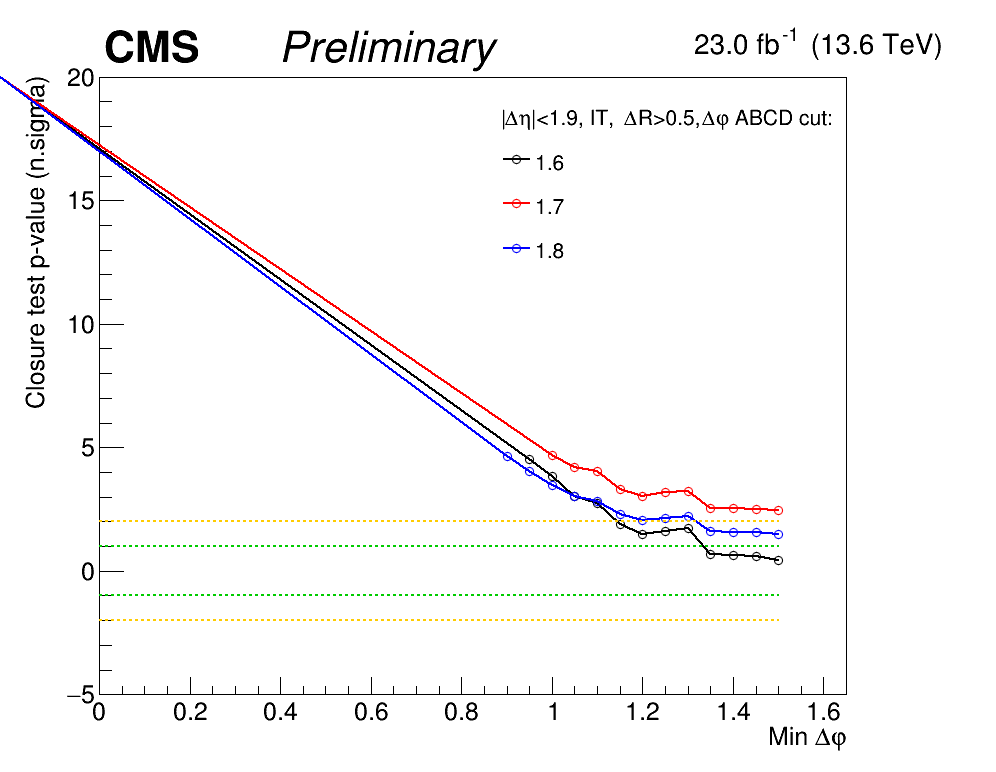

In [17]:
#now plot!                
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.65,0.65,0.88)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)
can.cd()
colors = [1,2,4,800,6,8,9,802]
graph = {}
zgraph = {}
for n,r in enumerate(dr_min_list):
    print(n)
    leg.SetHeader(leghead+"#Delta#varphi ABCD cut:")#" 1.7")
    for i, choice in enumerate([sigma_at_1p6[r], sigma_at_1p7[r], sigma_at_1p8[r]]):#]:
        labels = ["1.6","1.7","1.8"]
        graph[i] = rt.TGraph(len(phi_min_scan_list),np.array(phi_min_scan_list),np.array(choice))
        graph[i].SetTitle("")
        graph[i].SetMarkerStyle(24)
        graph[i].SetMarkerColor(colors[i])
        graph[i].SetLineWidth(2)
        graph[i].SetLineColor(colors[i])
        leg.AddEntry(graph[i],labels[i])#"#DeltaR>"+str(r),"PL")
        print(i, graph[i].Print())
        if i==0:
            graph[i].Draw("APL")
        else:
            graph[i].Draw("PL sames")
        graph[i].SetMinimum(-5)
        graph[i].SetMaximum(20)
        graph[i].GetXaxis().SetTitle("Min #Delta#varphi")
        graph[i].GetYaxis().SetTitle("Closure test p-value (n.sigma)")
        
        ##zvals = [z_at_1p6[r], z_at_1p7[r], z_at_1p8[r]]
        ##zgraph[i] = rt.TGraph(len(phi_min_scan_list),np.array(phi_min_scan_list),np.array(zvals[i]))
        ##zgraph[i].SetTitle("")
        ##zgraph[i].SetMarkerStyle(25)
        ##zgraph[i].SetMarkerColor(colors[i])
        ##zgraph[i].SetLineWidth(2)
        ##zgraph[i].SetLineColor(colors[i])
        ##leg.AddEntry(zgraph[i],labels[i])#"#DeltaR>"+str(r),"PL")
        ##print(i, zgraph[i].Print())
        ##if i==0:
        ##    zgraph[i].Draw("APL")
        ##else:
        ##    zgraph[i].Draw("PL sames")
        ##zgraph[i].SetMinimum(-5)
        ##zgraph[i].SetMaximum(20)
        ##zgraph[i].GetXaxis().SetTitle("Min #Delta#varphi")
        ##zgraph[i].GetYaxis().SetTitle("Closure test - p-value (n.sigma)")
    sigma2p = rt.TLine(phi_min_scan_list[0],2,phi_min_scan_list[-1],2)
    sigma1p = rt.TLine(phi_min_scan_list[0],1,phi_min_scan_list[-1],1)
    sigma1m = rt.TLine(phi_min_scan_list[0],-1,phi_min_scan_list[-1],-1)
    sigma2m = rt.TLine(phi_min_scan_list[0],-2,phi_min_scan_list[-1],-2)
    sigma2p.SetLineColor(800)
    sigma2m.SetLineColor(800)
    sigma1p.SetLineColor(417)
    sigma1m.SetLineColor(417)
    sigma2p.SetLineWidth(2)
    sigma2m.SetLineWidth(2)
    sigma1p.SetLineWidth(2)
    sigma1m.SetLineWidth(2)
    sigma2p.SetLineStyle(2)
    sigma2m.SetLineStyle(2)
    sigma1p.SetLineStyle(2)
    sigma1m.SetLineStyle(2)
    sigma2p.Draw("L sames")
    sigma1p.Draw("L sames")
    sigma2m.Draw("L sames")
    sigma1m.Draw("L sames")
    
    
leg.Draw()
can.SetRightMargin(0.15)
# if setlog: 
#can.SetLogy()
can.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.Print("plots/V1p19_"+vers+"/ABCD_closure_small_deta"+plot_string_plus+".pdf")
can.Print("plots/V1p19_"+vers+"/ABCD_closure_small_deta"+plot_string_plus+".png")

0
None
x[0]=0, y[0]=218.808, ex[0]=0, ey[0]=8.41461
x[1]=0.2, y[1]=251.806, ex[1]=0, ey[1]=10.079
x[2]=0.4, y[2]=250.754, ex[2]=0, ey[2]=10.5726
x[3]=0.5, y[3]=242.89, ex[3]=0, ey[3]=10.5881
x[4]=0.6, y[4]=245.724, ex[4]=0, ey[4]=11.1215
x[5]=0.7, y[5]=190.234, ex[5]=0, ey[5]=9.93365
x[6]=0.75, y[6]=155.604, ex[6]=0, ey[6]=9.01685
x[7]=0.8, y[7]=136.928, ex[7]=0, ey[7]=8.61816
x[8]=0.85, y[8]=119.713, ex[8]=0, ey[8]=8.24067
x[9]=0.9, y[9]=102.21, ex[9]=0, ey[9]=7.78524
x[10]=0.95, y[10]=89.3016, ex[10]=0, ey[10]=7.48113
x[11]=1, y[11]=79.8358, ex[11]=0, ey[11]=7.32242
x[12]=1.05, y[12]=71.4284, ex[12]=0, ey[12]=7.15847
x[13]=1.1, y[13]=68.5585, ex[13]=0, ey[13]=7.33238
x[14]=1.15, y[14]=59.25, ex[14]=0, ey[14]=7.10231
x[15]=1.2, y[15]=55.5247, ex[15]=0, ey[15]=7.22918
x[16]=1.25, y[16]=58.07, ex[16]=0, ey[16]=7.91762
x[17]=1.3, y[17]=60.0432, ex[17]=0, ey[17]=8.69131
x[18]=1.35, y[18]=48.5163, ex[18]=0, ey[18]=8.52893
x[19]=1.4, y[19]=48.2222, ex[19]=0, ey[19]=9.44655
x[20]=1.45, y[20]

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_pred_small_deta_exactly_2_csc_clusters_ME_veto_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_pred_small_deta_exactly_2_csc_clusters_ME_veto_IT_dR0p5.png has been created


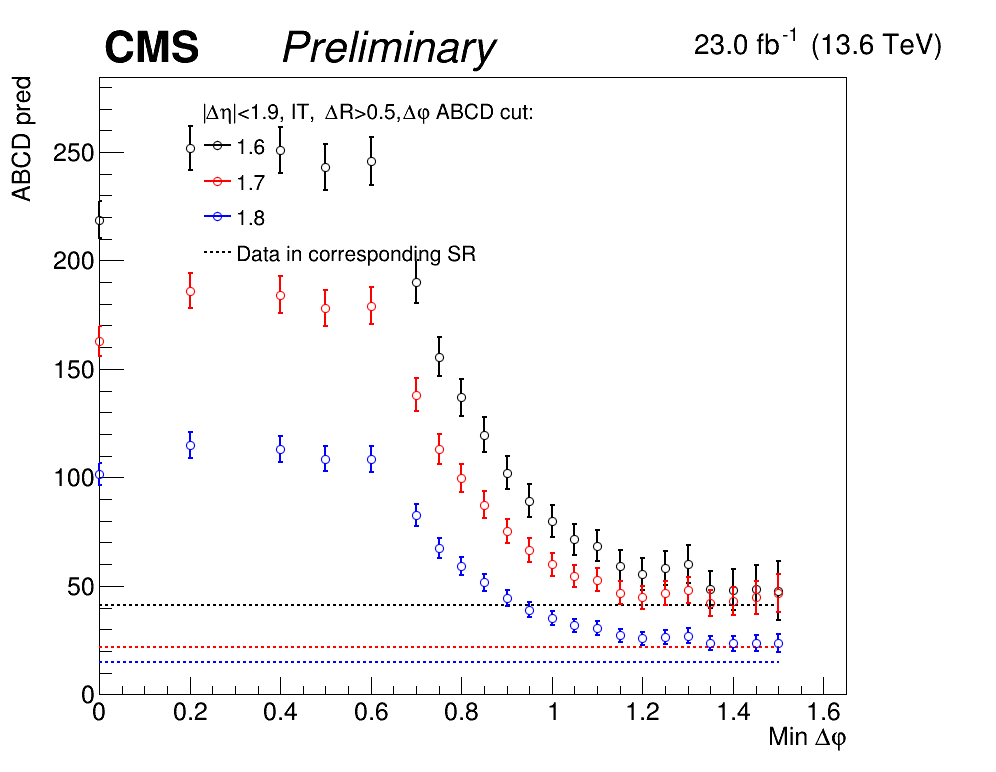

In [18]:
#now plot!                
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5-0.3,0.65,0.65-0.3,0.88)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)
can.cd()
colors = [1,2,4,800,6,8,9,802]
graph = {}
tl = {}
for n,r in enumerate(dr_min_list):
    print(n)
    leg.SetHeader(leghead+"#Delta#varphi ABCD cut:")#" 1.7")
    for i, choice in enumerate([bkg_at_1p6[r], bkg_at_1p7[r], bkg_at_1p8[r]]):#]:
        labels = ["1.6","1.7","1.8"]
        unc = [unc_at_1p6[r], unc_at_1p7[r], unc_at_1p8[r]]
        true_val = [true_at_1p6[r][0], true_at_1p7[r][0], true_at_1p8[r][0]]
        tl[i] = rt.TLine(phi_min_scan_list[0],true_val[i],phi_min_scan_list[-1],true_val[i])
        tl[i].SetLineColor(colors[i])
        tl[i].SetLineStyle(2)
        tl[i].SetLineWidth(2)
        graph[i] = rt.TGraphErrors(len(phi_min_scan_list),np.array(phi_min_scan_list),np.array(choice),np.zeros(len(unc[i])),np.array(unc[i]))
        graph[i].SetTitle("")
        graph[i].SetMarkerStyle(24)
        graph[i].SetMarkerColor(colors[i])
        graph[i].SetLineWidth(2)
        graph[i].SetLineColor(colors[i])
        leg.AddEntry(graph[i],labels[i])#"#DeltaR>"+str(r),"PL")
        if i==0:
            graph[i].Draw("AP")
            print(graph[i].Print())
        else:
            graph[i].Draw("P sames")
        tl[i].Draw("L sames")
        graph[i].SetMinimum(0)
        graph[i].GetXaxis().SetTitle("Min #Delta#varphi")
        graph[i].GetYaxis().SetTitle("ABCD pred")
    leg.AddEntry(tl[0],"Data in corresponding SR","L")
    sigma2p = rt.TLine(phi_min_scan_list[0],2,phi_min_scan_list[-1],2)
    sigma1p = rt.TLine(phi_min_scan_list[0],1,phi_min_scan_list[-1],1)
    sigma1m = rt.TLine(phi_min_scan_list[0],-1,phi_min_scan_list[-1],-1)
    sigma2m = rt.TLine(phi_min_scan_list[0],-2,phi_min_scan_list[-1],-2)
    sigma2p.SetLineColor(800)
    sigma2m.SetLineColor(800)
    sigma1p.SetLineColor(417)
    sigma1m.SetLineColor(417)
    sigma2p.SetLineWidth(2)
    sigma2m.SetLineWidth(2)
    sigma1p.SetLineWidth(2)
    sigma1m.SetLineWidth(2)
    sigma2p.SetLineStyle(2)
    sigma2m.SetLineStyle(2)
    sigma1p.SetLineStyle(2)
    sigma1m.SetLineStyle(2)
    #sigma2p.Draw("L sames")
    #sigma1p.Draw("L sames")
    #sigma2m.Draw("L sames")
    #sigma1m.Draw("L sames")
    
    
leg.Draw()
can.SetRightMargin(0.15)
# if setlog: 
#can.SetLogy()
can.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.Print("plots/V1p19_"+vers+"/ABCD_pred_small_deta"+plot_string_plus+".pdf")
can.Print("plots/V1p19_"+vers+"/ABCD_pred_small_deta"+plot_string_plus+".png")

0
None
x[0]=0, y[0]=81.2621, ex[0]=0, ey[0]=3.84567
x[1]=0.2, y[1]=83.7176, ex[1]=0, ey[1]=4.00269
x[2]=0.4, y[2]=83.6493, ex[2]=0, ey[2]=4.2163
x[3]=0.5, y[3]=83.1199, ex[3]=0, ey[3]=4.35922
x[4]=0.6, y[4]=83.3146, ex[4]=0, ey[4]=4.52604
x[5]=0.7, y[5]=78.4476, ex[5]=0, ey[5]=5.2218
x[6]=0.75, y[6]=73.6511, ex[6]=0, ey[6]=5.79474
x[7]=0.8, y[7]=70.0574, ex[7]=0, ey[7]=6.29391
x[8]=0.85, y[8]=65.7514, ex[8]=0, ey[8]=6.8837
x[9]=0.9, y[9]=59.8866, ex[9]=0, ey[9]=7.61689
x[10]=0.95, y[10]=54.0882, ex[10]=0, ey[10]=8.37737
x[11]=1, y[11]=48.6446, ex[11]=0, ey[11]=9.17185
x[12]=1.05, y[12]=42.5999, ex[12]=0, ey[12]=10.0219
x[13]=1.1, y[13]=40.197, ex[13]=0, ey[13]=10.6951
x[14]=1.15, y[14]=30.8017, ex[14]=0, ey[14]=11.987
x[15]=1.2, y[15]=26.159, ex[15]=0, ey[15]=13.0198
x[16]=1.25, y[16]=29.3956, ex[16]=0, ey[16]=13.6346
x[17]=1.3, y[17]=31.7158, ex[17]=0, ey[17]=14.4751
x[18]=1.35, y[18]=15.4922, ex[18]=0, ey[18]=17.5795
x[19]=1.4, y[19]=14.977, ex[19]=0, ey[19]=19.5896
x[20]=1.45, y[20]

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_closure_percentage_small_deta_exactly_2_csc_clusters_ME_veto_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_closure_percentage_small_deta_exactly_2_csc_clusters_ME_veto_IT_dR0p5.png has been created


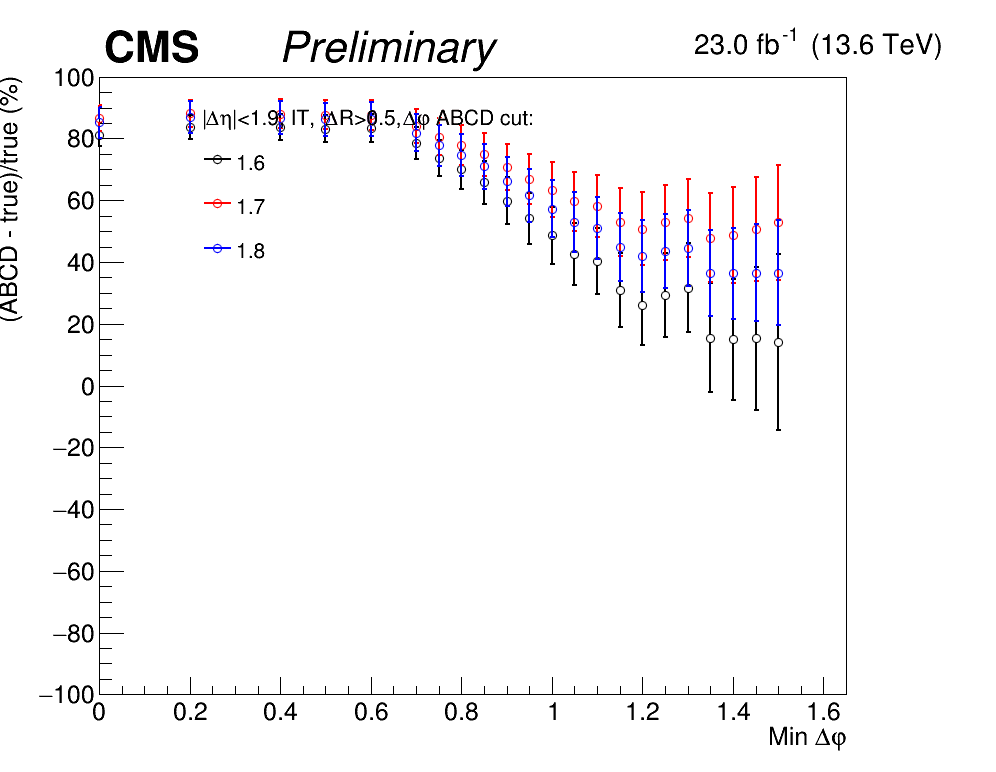

In [19]:
#now plot!                
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5-0.3,0.65,0.65-0.3,0.88)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)
can.cd()
colors = [1,2,4,800,6,8,9,802]
graph = {}
tl = {}
for n,r in enumerate(dr_min_list):
    print(n)
    leg.SetHeader(leghead+"#Delta#varphi ABCD cut:")#" 1.7")
    for i, choice in enumerate([bkg_at_1p6[r], bkg_at_1p7[r], bkg_at_1p8[r]]):#]:
        labels = ["1.6","1.7","1.8"]
        unc = [unc_at_1p6[r], unc_at_1p7[r], unc_at_1p8[r]]
        true_val = [true_at_1p6[r], true_at_1p7[r], true_at_1p8[r]]
        #tl[i] = rt.TLine(phi_min_scan_list[0],true_val[i],phi_min_scan_list[-1],true_val[i])
        #tl[i].SetLineColor(colors[i])
        #tl[i].SetLineStyle(2)
        #tl[i].SetLineWidth(2)
        choice = np.array(choice)
        true_val = np.array(true_val)
        graph[i] = rt.TGraphErrors(len(phi_min_scan_list),np.array(phi_min_scan_list),100*np.array( (choice - true_val[i])/choice),np.zeros(len(unc[i])),100*np.array(unc[i]/choice))
        graph[i].SetTitle("")
        graph[i].SetMarkerStyle(24)
        graph[i].SetMarkerColor(colors[i])
        graph[i].SetLineWidth(2)
        graph[i].SetLineColor(colors[i])
        leg.AddEntry(graph[i],labels[i])#"#DeltaR>"+str(r),"PL")
        if i==0:
            graph[i].Draw("AP")
            print(graph[i].Print())
        else:
            graph[i].Draw("P sames")
        graph[i].SetMinimum(-100)
        graph[i].SetMaximum(100)
        graph[i].GetXaxis().SetTitle("Min #Delta#varphi")
        graph[i].GetYaxis().SetTitle("(ABCD - true)/true (%)")
    #leg.AddEntry(tl[0],"Data in corresponding SR","L")
    sigma2p = rt.TLine(phi_min_scan_list[0],2,phi_min_scan_list[-1],2)
    sigma1p = rt.TLine(phi_min_scan_list[0],1,phi_min_scan_list[-1],1)
    sigma1m = rt.TLine(phi_min_scan_list[0],-1,phi_min_scan_list[-1],-1)
    sigma2m = rt.TLine(phi_min_scan_list[0],-2,phi_min_scan_list[-1],-2)
    sigma2p.SetLineColor(800)
    sigma2m.SetLineColor(800)
    sigma1p.SetLineColor(417)
    sigma1m.SetLineColor(417)
    sigma2p.SetLineWidth(2)
    sigma2m.SetLineWidth(2)
    sigma1p.SetLineWidth(2)
    sigma1m.SetLineWidth(2)
    sigma2p.SetLineStyle(2)
    sigma2m.SetLineStyle(2)
    sigma1p.SetLineStyle(2)
    sigma1m.SetLineStyle(2)
    #sigma2p.Draw("L sames")
    #sigma1p.Draw("L sames")
    #sigma2m.Draw("L sames")
    #sigma1m.Draw("L sames")
    
    
leg.Draw()
can.SetRightMargin(0.15)
# if setlog: 
#can.SetLogy()
can.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.Print("plots/V1p19_"+vers+"/ABCD_closure_percentage_small_deta"+plot_string_plus+".pdf")
can.Print("plots/V1p19_"+vers+"/ABCD_closure_percentage_small_deta"+plot_string_plus+".png")

/afs/desy.de/user/l/lbenato/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_i

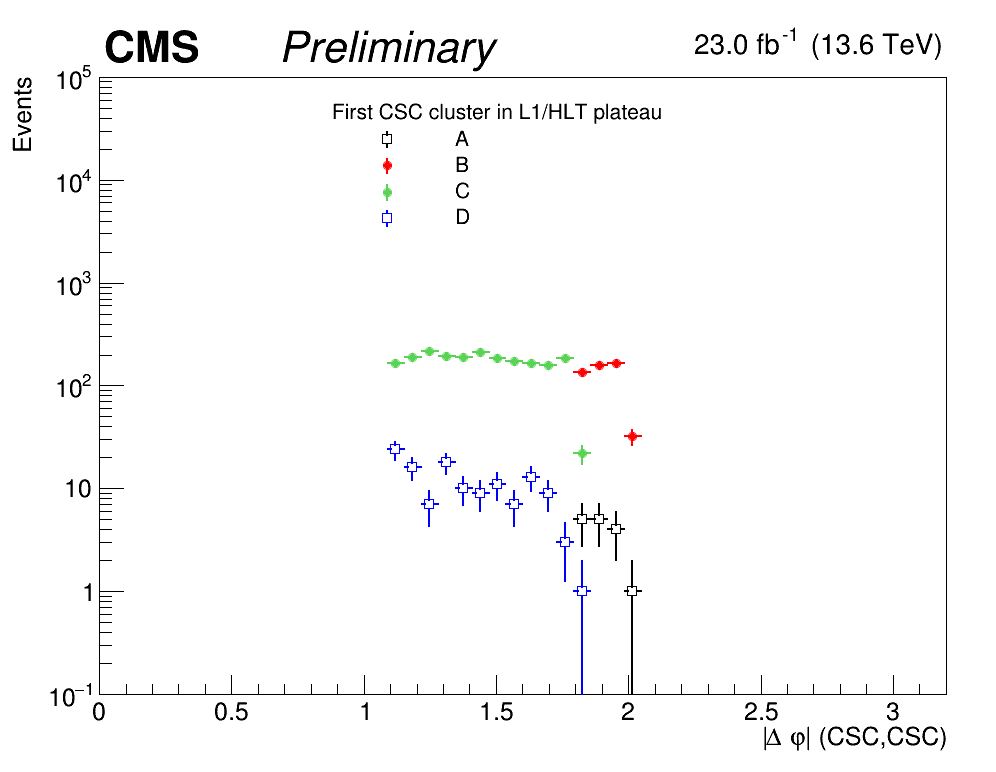

In [20]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.2,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""



if category==1:
    for k in ['data']:
        var = cscClusterSize[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        ma,mb,mc,md = return_abcd_masks(
                        var,dphi,
                        N_MIN,N_CUT,N_MAX,
                        PHI_MIN,PHI_CUT,PHI_MAX,
                        tmp_cut
                        )

        h0[k] = create_TH1D( dphi[ma],title="",axis_title = ['|#Delta #varphi| (CSC,CSC)','Events'], binning=[50,0,3.2])
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(25)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( dphi[mb],title="",axis_title = ['|#Delta #varphi| (CSC,CSC)','Events'], binning=[50,0,3.2])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
            
        h2[k] = create_TH1D(dphi[mc],title="",axis_title = ['phi','Events'], binning=[50,0,3.2])
        h2[k].SetLineColor(8)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(8)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral()) 
        
        h3[k] = create_TH1D(dphi[md],title="",axis_title = ['phi','Events'], binning=[50,0,3.2])
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(25)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.1)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.001)
        if 'data' in k:
            h0[k].Draw('PE same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            h3[k].Draw('PE same')
            leg.AddEntry(h0[k],"A","PE")
            leg.AddEntry(h1[k],"B","PE")
            leg.AddEntry(h2[k],"C","PE")
            leg.AddEntry(h3[k],"D","PE")


#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/ABCD_deltaPhi_distribution_small_deta"+plot_string_plus+".pdf")
can.Print("plots/V1p19_"+vers+"/ABCD_deltaPhi_distribution_small_deta"+plot_string_plus+".png") 